### Imports

In [1]:
cd ..

c:\Users\seand\OneDrive\Dokumente\Masterthesis\StarBoundaryNetworks\src


In [2]:
import torch
from torch import nn

from domains.starDomain import Sphere
from pdeOperators.operators import *
from lossFuncitons.pinnLossFunctions import *
from lossFuncitons.pinnNeuralOperatorLoss import *
from neuralOperators.imposedBCNeuralOperator import *
from neuralOperators.classicalNeuralOperators import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from scipy.interpolate import griddata
from ipywidgets import *
import numpy as np

%matplotlib widget

Problem is defined in the following way. Let $\Omega = B(0,1)$ be the open Ball with center at 0 and radius 1.
We want to find the solution of 

$\Delta u = f, ~ \text{on } \Omega $ and 

$ u = g, \text{ on } \partial \Omega $

For many $f \in C( \Omega )$ and one $g \in C(\partial \Omega)$ fix.


### Define some evaluation functions for which we know the analytic solution of the equation above

Set $g(x) =0 $ for our tests and we have

$\Delta g(x) = 0 $

In [3]:

def g(x):
    return (torch.zeros_like(x[0])  ).view(-1,1)

def laplace_g(x):
    return (torch.zeros_like(x[0]) ).view(-1,1)


We train and test on the function set 

$\{ \alpha \cdot u_1 + \beta \cdot u_2 + \gamma \cdot u_3 : ~ \alpha , \beta , \gamma \in [0,2] \}$

with 

$u_1(x) = ( ||x|| -1 ) \cdot \sin(x_1) + g(x)$

$u_2(x) = ( ||x||^2 -1 ) \cdot \exp(x_2) + g(x)$

$u_3(x) = ( ||x|| -1 ) \cdot \exp(- x_1^2)  + g(x)$

Note that all of these functions have in common that $ u_i \vert _{ \partial B(0,1)} = g \vert _{ \partial B(0,1)} $

The laplacians of these functions are:

$\Delta u_1(x) = { \sin(x_1) \over ||x||} + 2 {x_1 \cdot \cos(x_1) \over ||x||} - (||x|| -1 ) \sin(x_1) + 5 \cdot g(x)$

$\Delta u_2(x) = 4 \cdot e^{x_2} + 4 \cdot x_2 \cdot e^{x_2} +  (||x||^2 -1) e^{x_2}  +5 \cdot g(x)$

$\Delta u_3(x) = {1 \over ||x||} e^{-x_1^2} - 4 \cdot  {x_1 ^2 \over ||x||} e^{-x_1^2} - 2 \cdot (||x|| - 1) e^{x_1^2} + 4 \cdot x_1^2 (||x|| -1) e^{x_1^2} + 5 g(x)$

In [4]:
#these are some harmonic functions

def testFunc1(x):
    norm = torch.sqrt(x[0]*x[0] + x[1]*x[1])
    out = ( norm - 1 ) * torch.sin(x[0]) + g(x)
    return out.view(-1,1)

def laplaceTestFunc1(x):
    norm = torch.sqrt(x[0]*x[0] + x[1]*x[1])
    out = (torch.sin(x[0])+2*x[0] * torch.cos(x[0]))/norm - (norm -1)* torch.sin(x[0]) + laplace_g(x)
    return out.view(-1,1)

def testFunc2(x):
    normSquared = x[0]*x[0] + x[1]*x[1]
    out = ( normSquared - 1 ) *  torch.exp( x[1]) + g(x)
    return out.view(-1,1)

def laplaceTestFunc2(x):
    normSquared = x[0]*x[0] + x[1]*x[1]
    ex2 = torch.exp(x[1])
    out = 4*ex2 + 4*x[1] * ex2 + (normSquared -1)*ex2 + laplace_g(x)
    return out.view(-1,1)

def testFunc3(x):
   norm = torch.sqrt(x[0]*x[0] + x[1]*x[1])
   out = ( norm - 1 ) * torch.exp(- x[0] **2 ) + g(x)
   return out.view(-1,1)

def laplaceTestFunc3(x):
    norm = torch.sqrt(x[0]**2 + x[1]**2)
    exm1s = torch.exp(- x[0]**2)
    out = (1- 4* x[0]* x[0])* (exm1s/ norm) + (4*x[0]* x[0]-2)*(norm -1)* exm1s + laplace_g(x)
    return out.view(-1,1)


def trainFunc(x,a,b,c):
    return a*testFunc1(x) + b*testFunc2(x) + c*testFunc3(x)

def laplaceTrainFunc(x, a,b,c):
    return a*laplaceTestFunc1(x) + b*laplaceTestFunc2(x) + c*laplaceTestFunc3(x)

### Set Device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Generate Domain and Data Points on ball and on boundary

In [6]:
#generate Points for training
domain  = Sphere(2,torch.tensor([0.,0.]), torch.tensor(1.),device)
ballPoints = domain.generateCartesianRandomPointsFullDomain(2000)
bdPoints = domain.generateSphericalRandomPointsOnBoundary(500)

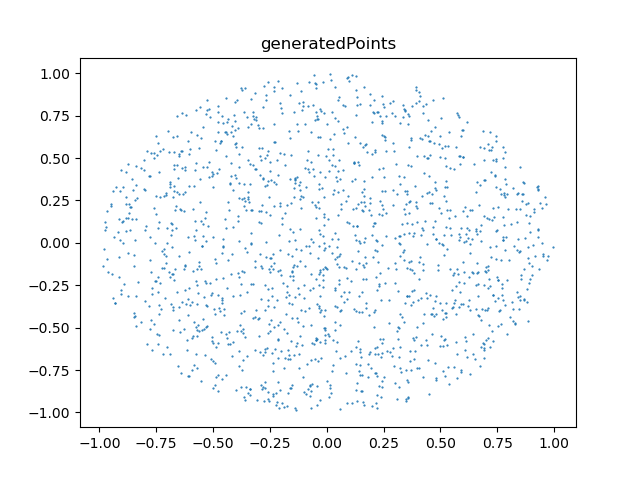

In [7]:
#plot generated points
pointsAsOneTensor = torch.cat(ballPoints, dim= 1).to("cpu")
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.set_title('generatedPoints')
ax1.scatter(pointsAsOneTensor[:,0],pointsAsOneTensor[:,1],s = 0.3)
plt.show()

#### Test if our derivatives are correct with generated points:

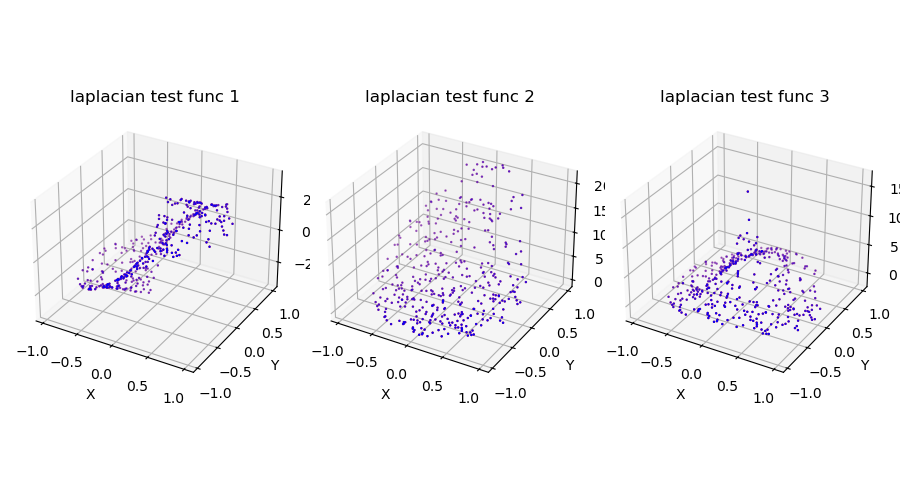

In [8]:
testPoints = domain.generateCartesianRandomPointsFullDomain(500)
testPoints[0].requires_grad = True
testPoints[1].requires_grad = True
testPoints[0] = testPoints[0].to('cpu')
testPoints[1] = testPoints[1].to('cpu')
testFunc1Out = testFunc1(testPoints)
testFunc2Out = testFunc2(testPoints)
testFunc3Out = testFunc3(testPoints)
x = testPoints[0].view(-1).detach().numpy()
y = testPoints[1].view(-1).detach().numpy()

z1an = laplaceTestFunc1(testPoints).view(-1).detach().numpy()
z1num = laplacian(testFunc1Out, testPoints).view(-1).detach().numpy()

z2an = laplaceTestFunc2(testPoints).view(-1).detach().numpy()
z2num = laplacian(testFunc2Out, testPoints).view(-1).detach().numpy()

z3an = laplaceTestFunc3(testPoints).view(-1).detach().numpy()
z3num = laplacian(testFunc3Out, testPoints).view(-1).detach().numpy()


figS3D = plt.figure(figsize=(9, 5))
# Create a 3D plot
axS3D1 = figS3D.add_subplot(131, projection='3d')
axS3D2 = figS3D.add_subplot(132, projection='3d')
axS3D3 = figS3D.add_subplot(133, projection='3d')

#set labels 
axS3D1.set_title('laplacian test func 1')
axS3D1.set_xlabel('X')
axS3D1.set_ylabel('Y')


axS3D2.set_title('laplacian test func 2')
axS3D2.set_xlabel('X')
axS3D2.set_ylabel('Y')

axS3D3.set_title('laplacian test func 3')
axS3D3.set_xlabel('X')
axS3D3.set_ylabel('Y')




# Plot the surface
axS3D1.scatter(x, y, z1an, c= "blue", s = 0.5)
axS3D1.scatter(x,y,z1num, c = 'red' , s = 0.5)


axS3D2.scatter(x, y, z2an, c = 'blue', s = 0.5)
axS3D2.scatter(x,y,z2num, c = 'red', s = 0.5 )

axS3D3.scatter(x, y, z3an, c = 'blue', s = 0.5)
axS3D3.scatter(x,y,z3num, c = 'red', s = 0.5 )


# Show plot
plt.tight_layout()
plt.show()



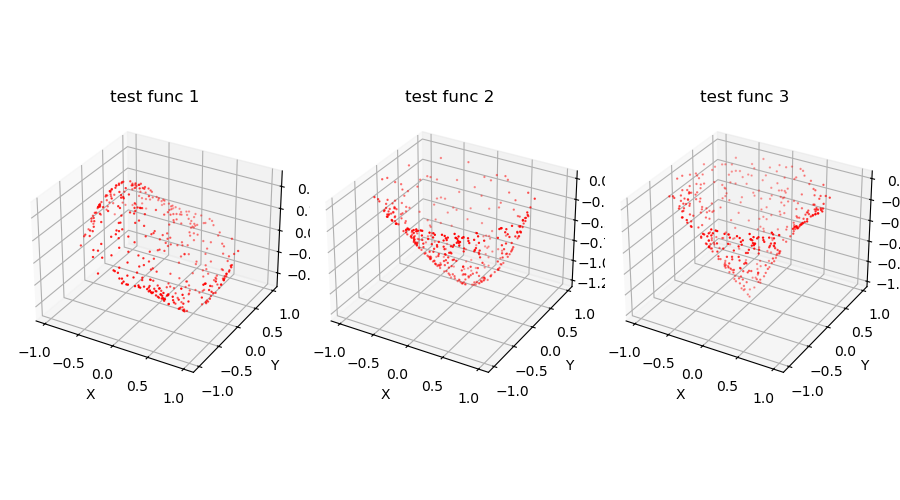

In [9]:
testPoints = domain.generateCartesianRandomPointsFullDomain(500)
testPoints[0].requires_grad = True
testPoints[1].requires_grad = True
testPoints[0] = testPoints[0].to('cpu')
testPoints[1] = testPoints[1].to('cpu')
testFunc1Out = testFunc1(testPoints)
testFunc2Out = testFunc2(testPoints)
testFunc3Out = testFunc3(testPoints)
x = testPoints[0].view(-1).detach().numpy()
y = testPoints[1].view(-1).detach().numpy()


z1num = testFunc1Out.view(-1).detach().numpy()

z2num = testFunc2Out.view(-1).detach().numpy()

z3num = testFunc3Out.view(-1).detach().numpy()


figS3D = plt.figure(figsize=(9, 5))
# Create a 3D plot
axS3D1 = figS3D.add_subplot(131, projection='3d')
axS3D2 = figS3D.add_subplot(132, projection='3d')
axS3D3 = figS3D.add_subplot(133, projection='3d')

#set labels 
axS3D1.set_title('test func 1')
axS3D1.set_xlabel('X')
axS3D1.set_ylabel('Y')


axS3D2.set_title('test func 2')
axS3D2.set_xlabel('X')
axS3D2.set_ylabel('Y')

axS3D3.set_title('test func 3')
axS3D3.set_xlabel('X')
axS3D3.set_ylabel('Y')




# Plot the surface
axS3D1.scatter(x,y,z1num, c = 'red' , s = 0.5)


axS3D2.scatter(x,y,z2num, c = 'red', s = 0.5 )

axS3D3.scatter(x,y,z3num, c = 'red', s = 0.5 )


# Show plot
plt.tight_layout()
plt.show()


In [11]:
createNewModel = False

if createNewModel:
    solOperatorImposed = ImposedBCDeepONetSphere2D_DomainFuncToSol(    
                                                n_hidden_trunk = 500,
                                                n_layers_trunk = 2,
                                                n_hidden_branch = 500,
                                                n_layers_branch = 3,
                                                domain = domain,
                                                nFixDomPoints = 500,
                                                boundaryFunction = g
                                                )
else:
    solOperatorImposed = torch.load("./trainedModels/poissonImposedDeepONet.pt")


In [12]:
createNewModel = False

if createNewModel:
    solOperatorClassical = DeepONetSphere2D_DomainFuncToSol(    
                                    n_hidden_trunk = 500,
                                    n_layers_trunk = 2,
                                    n_hidden_branch = 500,
                                    n_layers_branch = 3,
                                    fixDomPoints = domain.generateCartesianRandomPointsFullDomain(500)
                                                    )
else:
    solOperatorClassical = torch.load("./trainedModels/poissonClassicalDeepONet.pt")

### Setting for Training

#### Setting for Training Imposed DeepONet

In [13]:
xy_grid = ballPoints
xy_grid[0].requires_grad = True
xy_grid[1].requires_grad = True
bdPoints[0].requires_grad = True
bdPoints[1].requires_grad = True
epochs = 10000
learningRate  = 5e-4
boundaryFunctionBatchSize = 20

In [14]:
#move everything to right device
xy_grid[0] = xy_grid[0].to(device)
xy_grid[1] = xy_grid[1].to(device)
bdPoints[0] = bdPoints[0].to(device)
bdPoints[1] = bdPoints[1].to(device)
print()

In [15]:
#define optimizer
optimizerImposed = torch.optim.Adam(solOperatorImposed.parameters(), lr = learningRate)
optimizerClassical = torch.optim.Adam(solOperatorClassical.parameters(), lr = learningRate)

## Training

### Trainig ImposedDeepONet

In [15]:
# move model to device
solOperatorImposed.updateDevice(device)

In [16]:
#computes initial loss to see where we start
loss = poissonEquationLossOperator(u = solOperatorImposed, xgrid=xy_grid, domainFunction = lambda grid : laplaceTrainFunc(grid,1,1,1), device = device )
minLossImposed = loss.item()
minLossImposed

2.1575145759297616

In [17]:
#training
for i in range(epochs):
    optimizerImposed.zero_grad()
    #add loss of N rdm generated funcitons
    aRand,bRand, cRand = torch.rand(3)*2
    loss = poissonEquationLossOperator(u = solOperatorImposed, xgrid=xy_grid, domainFunction = lambda grid : laplaceTrainFunc(grid,aRand,bRand, cRand), device = device )
    for funcIdx in range(boundaryFunctionBatchSize - 1):
        aRand,bRand, cRand = torch.rand(3) *2
        loss = loss + poissonEquationLossOperator(u = solOperatorImposed, xgrid=xy_grid, domainFunction = lambda grid : laplaceTrainFunc(grid,aRand,bRand, cRand), device = device )
    loss = loss / boundaryFunctionBatchSize
    if loss.item() < minLossImposed:
        minLossImposed = loss.item()
        print("found better model")
        torch.save(solOperatorImposed, "./trainedModels/poissonImposedDeepONet.pt")
    if i%10 == 0:
        print(f"epoch {i}")
        print(loss.item())
    loss.backward(retain_graph=True)
    optimizerImposed.step()

found better model
epoch 0
1.69741439431853
found better model
epoch 10
1.5888435679904052
found better model
epoch 20
1.6168481763202764
epoch 30
2.0868929562125205
found better model
epoch 40
2.4822972681151363
epoch 50
2.1451429515200924
epoch 60
2.587069310098448
epoch 70
1.5983841706565785
epoch 80
2.0028640572534018
found better model
found better model
epoch 90
1.7210682625521152
epoch 100
2.160028860986031
found better model
epoch 110
1.26029266886766
epoch 120
2.0473887258441823
epoch 130
2.5233916122617894
epoch 140
1.527505608088917
epoch 150
1.9982578695980746
epoch 160
1.7795340785148124
epoch 170
1.6072047621675958
found better model
epoch 180
2.167635926153663
epoch 190
1.5902444415349726
epoch 200
2.0602945127544934
epoch 210
1.2897765575832565
epoch 220
2.2705382452920992
epoch 230
1.4713103122227833
epoch 240
1.639747984354024
epoch 250
1.5993065020258088
found better model
epoch 260
1.0993098291240153
epoch 270
1.7565799477140844
epoch 280
2.39631277125361
epoch 290


In [18]:
loadBestModel = False

if createNewModel:
    solOperatorImposed = torch.load("./trainedModels/poissonImposedDeepONet.pt")

In [16]:
# move model to cpu
solOperatorImposed.updateDevice("cpu")

### Training classical DeepONet

In [20]:
# move model to device
solOperatorClassical.updateDevice(device)

In [21]:
#computes initial loss to see where we start
loss = poissonEquationLossOperator(u = solOperatorClassical, xgrid = xy_grid,domainFunction = lambda grid : laplaceTrainFunc(grid,1,1,1),fixBoundaryFunction = g, boundaryPoints = bdPoints, device = device, beta = 1 )
minLossClassical = loss.item()
minLossClassical

0.3045160630682729

In [22]:
#training
for i in range(epochs):
    solOperatorClassical.zero_grad()
    #add loss of N rdm generated funcitons
    aRand,bRand, cRand = torch.rand(3)*2
    loss = poissonEquationLossOperator(u = solOperatorClassical, xgrid = xy_grid,domainFunction = lambda grid : laplaceTrainFunc(grid,1,1,1),fixBoundaryFunction = g, boundaryPoints = bdPoints, device = device, beta = 10  )
    for funcIdx in range(boundaryFunctionBatchSize - 1):
        aRand,bRand, cRand = torch.rand(3) *2
        loss = loss + poissonEquationLossOperator(u = solOperatorClassical, xgrid = xy_grid,domainFunction = lambda grid : laplaceTrainFunc(grid,1,1,1),fixBoundaryFunction = g, boundaryPoints = bdPoints, device = device, beta = 10  )
    loss = loss / boundaryFunctionBatchSize
    if loss.item() < minLossClassical:
        minLossClassical = loss.item()
        print("found better model")
        torch.save(solOperatorClassical, "./trainedModels/poissonClassicalDeepONet.pt")
    if i%10 == 0:
        print(f"epoch {i}")
        print(loss.item())
    loss.backward(retain_graph=True)
    optimizerClassical.step()

epoch 0
0.39873926248049957
epoch 10
4.973383279805476
epoch 20
3.360105054089274
epoch 30
1.1597255305357794
epoch 40
1.4912967988746777
epoch 50
0.973833105986376
epoch 60
0.7003212324794639
epoch 70
0.8062338267078142
epoch 80
1.0098736953494023
epoch 90
0.8420519035866006
epoch 100
0.7218678005807004
epoch 110
0.7553133561129465
epoch 120
0.8060373524083819
epoch 130
0.6866939803796277
epoch 140
0.591058758647421
epoch 150
0.6610005023854099
epoch 160
0.36425607489339945
epoch 170
0.4483474657056654
epoch 180
0.590595406398716
epoch 190
0.6884661204515479
epoch 200
0.8645753996722028
epoch 210
0.4147224217547842
epoch 220
1.070662832895657
epoch 230
1.1691966362268251
epoch 240
0.6454961356938287
epoch 250
0.5595021001584594
epoch 260
0.3613169365641573
epoch 270
0.5955096051802732
epoch 280
0.93050256152608
epoch 290
0.647795218579565
epoch 300
0.6096429463880105
epoch 310
0.4954199233473097
epoch 320
0.4913481139624784
epoch 330
0.45077121567344247
epoch 340
0.3814761670139389
ep

In [23]:
loadBestModel = False

if createNewModel:
    solOperatorClassical = torch.load("./trainedModels/poissonClassicalDeepONet.pt")

In [17]:
# move model to device
solOperatorClassical.updateDevice("cpu")

### Visualize/Evaluate

In [18]:
xy_grid[0] = xy_grid[0].to("cpu")
xy_grid[1] = xy_grid[1].to("cpu")

#### Mix of Test Functions

In [27]:
#test with mix test function:
coeffs = torch.rand(3)*2
myTestFunc = lambda grid : trainFunc(grid,coeffs[0],coeffs[1],coeffs[2])
laplaceMyTestFunc = lambda grid : laplaceTrainFunc(grid,coeffs[0],coeffs[1],coeffs[2])

neuralOpOutImposed_Mix = solOperatorImposed(xy_grid, laplaceMyTestFunc)
neuralOpOutClassical_Mix = solOperatorClassical(xy_grid, laplaceMyTestFunc)
#laplacianImposed_Mix = laplacian(neuralOpOutImposed_Mix, xy_grid, device = "cpu")
#laplacianClassical_Mix = laplacian(neuralOpOutClassical_Mix, xy_grid, device = "cpu")
trueOut = trainFunc(xy_grid,coeffs[0],coeffs[1],coeffs[2])

absDifferenceTrueImposed = torch.abs(trueOut - neuralOpOutImposed_Mix)
absDifferenceTrueClassical = torch.abs(trueOut - neuralOpOutClassical_Mix)

errorImposed = torch.norm(absDifferenceTrueImposed) /torch.norm(trueOut)
errorClassical = torch.norm(absDifferenceTrueClassical)/torch.norm(trueOut)

maxErrorImposed = torch.max(absDifferenceTrueImposed)/torch.max(torch.abs(trueOut))
maxErrorClassical = torch.max(absDifferenceTrueClassical)/torch.max(torch.abs(trueOut))

In [28]:
#print errors
print(f"L2 Error of classical DeepONet:                        {errorClassical }")
print(f"L2 Error of DeepONet with imposed Dirichlet condition: {errorImposed }")

print(f"Max Error of classical DeepONet:                        {maxErrorClassical}")
print(f"Max Error of DeepONet with imposed Dirichlet condition: {maxErrorImposed}")

L2 Error of classical DeepONet:                        0.25013405084609985
L2 Error of DeepONet with imposed Dirichlet condition: 0.28950777649879456
Max Error of classical DeepONet:                        0.26688283681869507
Max Error of DeepONet with imposed Dirichlet condition: 0.29389166831970215


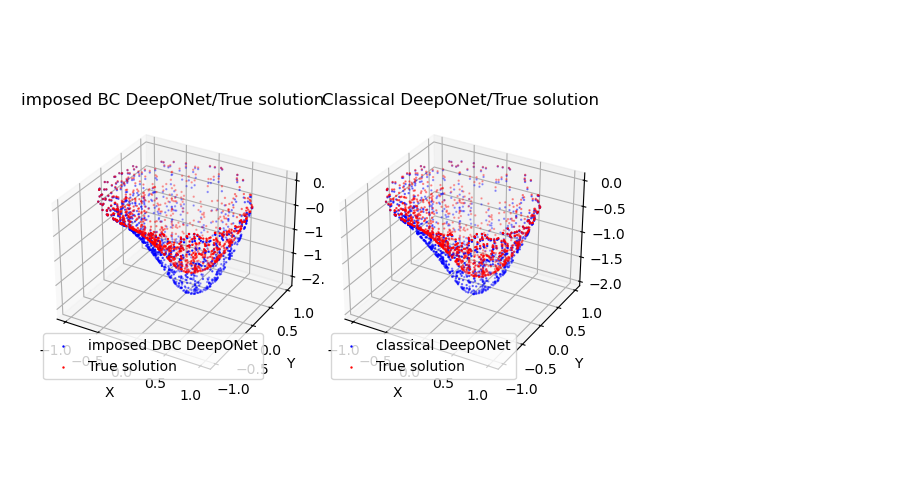

In [29]:
numPointsPlot = min(1000, xy_grid[0].shape[0])

x = xy_grid[0][:numPointsPlot].to("cpu").view(-1).detach().numpy()
y = xy_grid[1][:numPointsPlot].to("cpu").view(-1).detach().numpy()

zImposedDeepONet = neuralOpOutImposed_Mix[:numPointsPlot].to("cpu").view(-1).detach().numpy()
zClassicalDeepONet = neuralOpOutClassical_Mix[:numPointsPlot].to("cpu").view(-1).detach().numpy()

ztrue = trueOut[:numPointsPlot].to("cpu").view(-1).detach().numpy()


figS3D = plt.figure(figsize=(9, 5))
# Create a 3D plot
axS3D1 = figS3D.add_subplot(131, projection='3d')
axS3D2 = figS3D.add_subplot(132, projection='3d')

#set labels 
axS3D1.set_title('imposed BC DeepONet/True solution')
axS3D1.set_xlabel('X')
axS3D1.set_ylabel('Y')


axS3D2.set_title('Classical DeepONet/True solution')
axS3D2.set_xlabel('X')
axS3D2.set_ylabel('Y')





# Plot the surface
axS3D1.scatter(x, y, zImposedDeepONet, c= "blue", s = 0.5)
axS3D1.scatter(x,y,ztrue, c = 'red' , s = 0.5)
axS3D1.legend(['imposed DBC DeepONet', 'True solution'])

axS3D2.scatter(x, y, zClassicalDeepONet, c = 'blue', s = 0.5)
axS3D2.scatter(x,y,ztrue, c = 'red', s = 0.5 )
axS3D2.legend(['classical DeepONet', 'True solution'])



# Show plot
plt.tight_layout()
plt.show()

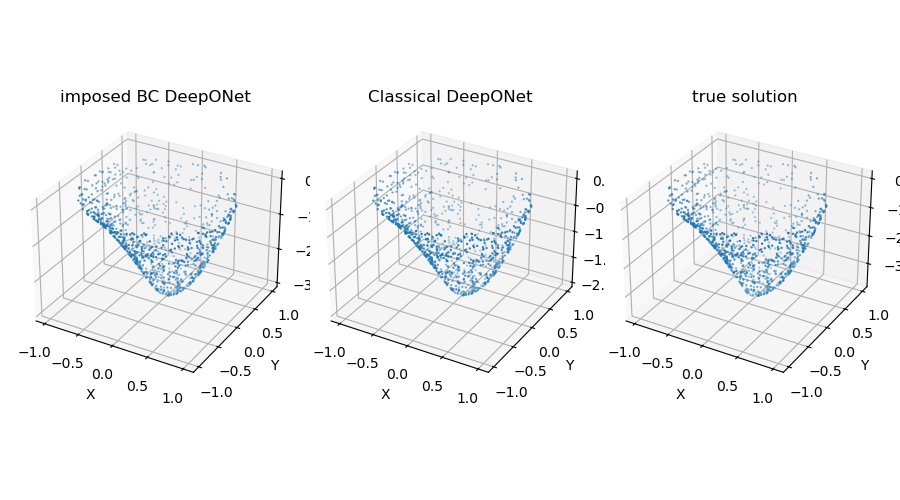

In [22]:
numPointsPlot = min(1000, xy_grid[0].shape[0])

x = xy_grid[0][:numPointsPlot].to("cpu").view(-1).detach().numpy()
y = xy_grid[1][:numPointsPlot].to("cpu").view(-1).detach().numpy()

zImposedDeepONet = neuralOpOutImposed_Mix[:numPointsPlot].to("cpu").view(-1).detach().numpy()
zClassicalDeepONet = neuralOpOutClassical_Mix[:numPointsPlot].to("cpu").view(-1).detach().numpy()

ztrue = trueOut[:numPointsPlot].to("cpu").view(-1).detach().numpy()


figS3D = plt.figure(figsize=(9, 5))
# Create a 3D plot
axS3D1 = figS3D.add_subplot(131, projection='3d')
axS3D2 = figS3D.add_subplot(132, projection='3d')
axS3D3 = figS3D.add_subplot(133, projection='3d')

#set labels 
axS3D1.set_title('imposed BC DeepONet')
axS3D1.set_xlabel('X')
axS3D1.set_ylabel('Y')

axS3D2.set_title('Classical DeepONet')
axS3D2.set_xlabel('X')
axS3D2.set_ylabel('Y')

axS3D3.set_title('true solution')
axS3D3.set_xlabel('X')
axS3D3.set_ylabel('Y')


# Plot the surface
axS3D1.scatter(x, y, zImposedDeepONet , s = 0.5)
axS3D2.scatter(x, y, zClassicalDeepONet, s = 0.5)
axS3D3.scatter(x, y, ztrue, s = 0.5)



# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Plot losses on training data points as heatmap

sampleSizeForDrawing = min(1000, xy_grid[0].shape[0])

data = np.empty((sampleSizeForDrawing,3))
data[:,0] = xy_grid[0][:sampleSizeForDrawing].to("cpu").view(-1).detach().numpy()
data[:,1] = xy_grid[1][:sampleSizeForDrawing].to("cpu").view(-1).detach().numpy()
data[:,2] = zClassicalDeepONet[:sampleSizeForDrawing].view(-1).detach().numpy()

# Create a meshgrid to interpolate over (choose grid resolution as needed)
grid_x, grid_y = np.mgrid[min(data[:, 0]):max(data[:, 0]):1000j, 
                          min(data[:, 1]):max(data[:, 1]):1000j]

# Interpolate the z values over the grid
grid_z = griddata((data[:, 0], data[:, 1]), data[:, 2], (grid_x, grid_y), method='cubic')



# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.pcolormesh(grid_x, grid_y, grid_z, cmap='coolwarm', shading='auto')
plt.colorbar()  # Add colorbar to the side
plt.title("Laplacian of problem with x1^2-x2^2 on boundary")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

TypeError: Cannot interpret '-1' as a data type

C:\Users\seand\AppData\Local\Temp\ipykernel_20568\3874768985.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z, cmap='viridis',c = 'blue')
C:\Users\seand\AppData\Local\Temp\ipykernel_20568\3874768985.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x,y,ztrue, cmap = 'viridis', c = 'red' )


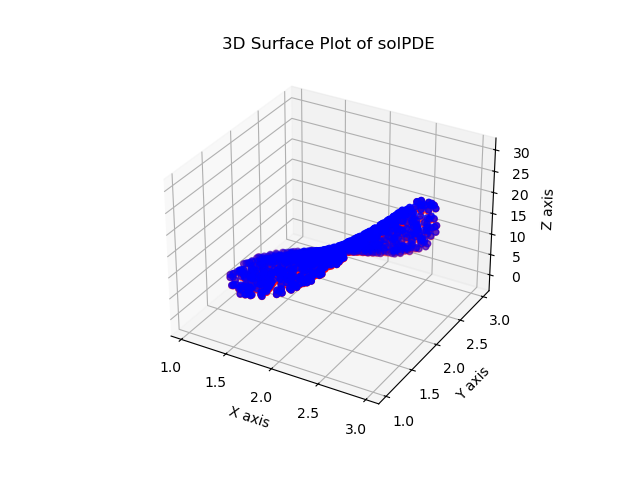

In [ ]:
numPointsPlot = min(1000, xy_grid[0].shape[0])
x = xy_grid[0][:numPointsPlot].to("cpu").view(-1).detach().numpy()
y = xy_grid[1][:numPointsPlot].to("cpu").view(-1).detach().numpy()


ztrue = trueOut[:numPointsPlot].to("cpu").view(-1).detach().numpy()



z = neuralOpOutImposed_Mix[:numPointsPlot].to("cpu").view(-1).detach().numpy()

# Create a 3D plot
fig6 = plt.figure()
ax6 = fig6.add_subplot(111, projection='3d')

# Plot the surface
ax6.scatter(x, y, z, cmap='viridis',c = 'blue')
ax6.scatter(x,y,ztrue, cmap = 'viridis', c = 'red' )

# Add labels and title
ax6.set_xlabel('X axis')
ax6.set_ylabel('Y axis')
ax6.set_zlabel('Z axis')
ax6.set_title('3D Surface Plot of solPDE')

# Show plot
plt.show()